In [2]:
using LinearAlgebra, Plots, ForwardDiff, PreallocationTools
using Preferences, BenchmarkTools

In [21]:
nₓ = 64
Δx = 2π/nₓ
Δt = 2Δx
rank = 2

# preallocations
x = zeros(nₓ)
x_new = zeros(nₓ)
y = zeros(nₓ)
y_new = zeros(nₓ)
Ψ = randn(nₓ, rank)

# set initial condition
x .= [v for v ∈ range(0., 2π - Δx, nₓ)] 
y .= sin.(x) .+ 0.1*randn(nₓ)

# caches that support ForwardDiff:
struct burger_app
    x_d::DiffCache
    y_d::DiffCache
    xtmp_d::DiffCache
    ytmp_d::DiffCache
    Ψ_d::DiffCache
end
burger = burger_app(
    DiffCache(x),
    DiffCache(x_new),
    DiffCache(y),
    DiffCache(y_new),
    DiffCache(Ψ)
);

In [22]:
function interp_periodic(coord, f)
    bound = nₓ
    # r, i = modf(coord / Δx)
    scaled = coord / Δx
    i = trunc(scaled)
    r = scaled - i
    i = mod1(Int(i+1), bound)
    (1 - r)*f[i] + r*f[mod1(i+1, bound)]
end

function semi_lagrangian(y, Δt, burger::burger_app)
    # load from caches (load normal data for y Real, load diffcache for y Dual)
    x = get_tmp(burger.x_d, y)
    # x_back = get_tmp(burger.xtmp_d, y)
    y_intp = get_tmp(burger.ytmp_d, y)

    x_back = x .- Δt * y
    y_intp .= interp_periodic.(x_back, Ref(y))
    y .= y_intp
    return y
end

semi_lagrangian (generic function with 1 method)

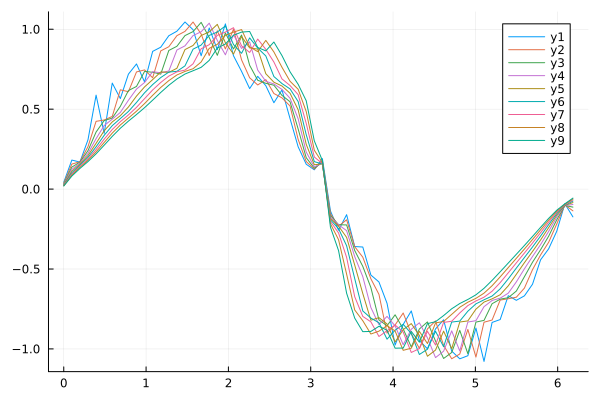

In [23]:
Δt = Δx
p = plot(x, y)
for t in 1:8
    y = semi_lagrangian(y, Δt, burger)
    plot!(x, y)
end
display(p)

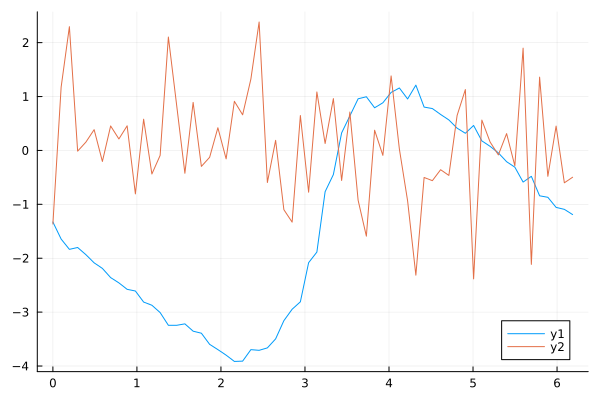

In [24]:
d = ForwardDiff.derivative(0.) do r
    y_loc = get_tmp(burger.y_d, r)
    Ψ_loc = get_tmp(burger.Ψ_d, r)
    y_loc .= y
    Ψ_loc .= Ψ
    semi_lagrangian(y_loc + Ψ[:,1]*r, Δt, burger)
end
plot(x, d)
plot!(x, Ψ[:,1])

In [14]:
ForwardDiff.jacobian(zeros(rank)) do r
    y_loc = get_tmp(burger.y_d, r)
    Ψ_loc = get_tmp(burger.Ψ_d, r)
    y_loc .= y
    Ψ_loc .= Ψ
    semi_lagrangian(y_loc + Ψ_loc*r, Δt, burger)
end

64×2 Matrix{Float64}:
 -0.114905    0.6883
 -0.208442    0.7525
 -0.187292    0.671092
 -0.30692     0.804005
 -0.324947    0.883922
 -0.330436    0.826443
 -0.334625    0.930339
 -0.406053    0.935748
 -0.491469    0.99259
 -0.55178     0.918119
  ⋮           
  0.326268    0.420525
  0.296654    0.57724
  0.206623    0.446517
  0.113078    0.553178
  0.12817     0.509926
  0.176114    0.573706
 -0.00988418  0.578995
  0.0249425   0.717563
 -0.0713982   0.76659

In [9]:
y_tmp = get_tmp(burger.y_d, x)

32-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0